In [1]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras import layers
import matplotlib.pyplot as plt
from wandb.integration.keras import WandbCallback
import os
import cv2
import numpy as np
import random

# Data loading

### Loading raw files

In [2]:
screen_x = 3840
screen_y = 2200
directory = "FEB_16"
images_path = f"C:\\Users\\Cyril\\Desktop\\data-science-lab\\eyeball tracker\\{directory}"

In [3]:
images = []
file_list = [f for f in os.listdir(images_path) if f.endswith((".jpg", ".jpeg")) and os.path.splitext(f)[0].isdigit()]

for f in sorted(file_list, key=lambda x: int(os.path.splitext(x)[0])):
    img = cv2.imread(os.path.join(images_path, f), cv2.IMREAD_GRAYSCALE)
    images.append(img)

images = np.array(images, dtype=np.uint8)

In [4]:
len(images)

2500

In [5]:
len(images[0])

480

In [6]:
len(images[0][0])

640

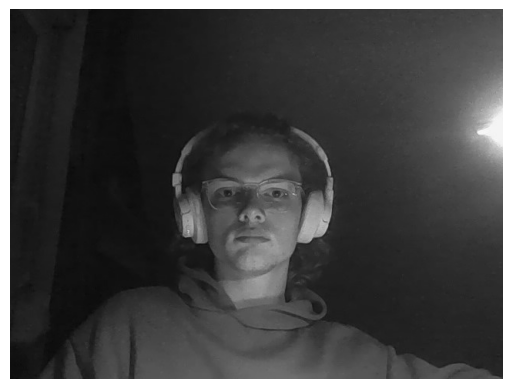

In [7]:
import matplotlib.pyplot as plt

rgb_image = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.axis("off")
plt.show()

In [8]:
targets = pd.read_csv(f"C:\\Users\\Cyril\\Desktop\\data-science-lab\\eyeball tracker\\{directory}\\target.csv", index_col="id")
targets.head(10)

,x_coordinate,y_coordinate
id,,
0,1773,942
1,1537,720
2,1541,690
3,1552,655
4,1575,614
5,1632,577
6,1711,548
7,1785,524
8,1870,505


In [9]:
targets["x_coordinate"] = targets["x_coordinate"] / screen_x
targets["y_coordinate"] = targets["y_coordinate"] / screen_y
targets.head(10)

,x_coordinate,y_coordinate
id,,
0,0.461719,0.428182
1,0.400260,0.327273
2,0.401302,0.313636
3,0.404167,0.297727
4,0.410156,0.279091
5,0.425000,0.262273
6,0.445573,0.249091
7,0.464844,0.238182
8,0.486979,0.229545


In [10]:
targets.describe()

,x_coordinate,y_coordinate
count,2500.000000,2500.000000
mean,0.497996,0.443771
std,0.304185,0.287195
min,0.002604,0.000000
25%,0.225716,0.178977
50%,0.475000,0.428636
75%,0.775781,0.699432
max,0.999740,0.952273


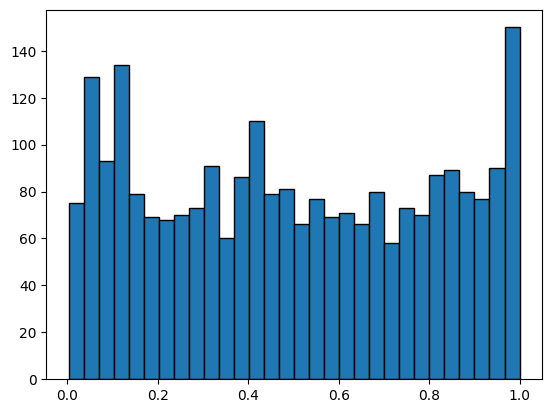

In [11]:
plt.hist(targets["x_coordinate"], bins=30, edgecolor='black')
plt.show()

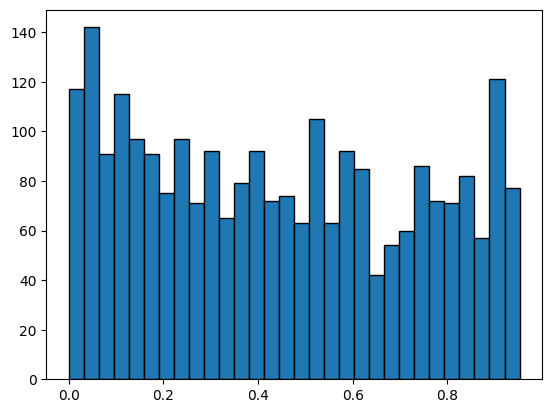

In [12]:
plt.hist(targets["y_coordinate"], bins=30, edgecolor='black')
plt.show()

### Feature scaling

In [13]:
images = np.array(images, dtype=np.float32) / 255.0

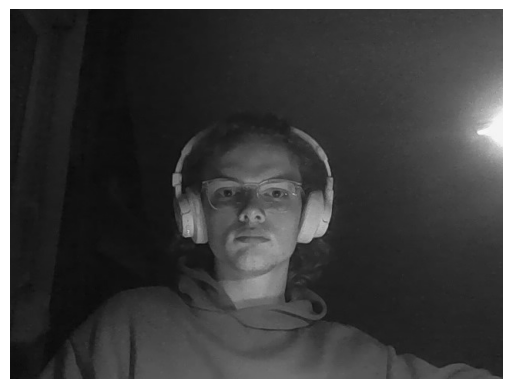

In [14]:
rgb_image = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.axis("off")
plt.show()

### train test split

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, shuffle=True, random_state=42)

## setting train variables

# Train

In [16]:
import wandb

In [ ]:
batch_size=32
epochs = 300
image_resize = 128
activation = "leaky_relu"
nb_layers = 2
nb_neurons = 128
dropout_rate = 0.0
optimizer = "adam"
optimizer_lr=0
loss = "mse"
metric = "mae"
augmentation = False

In [18]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

with tf.device('/CPU:0'):
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(len(x_test))

solved gpu overfeeding idk how, magic occured

In [20]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch.shape, label_batch.shape)


(480, 640) (2,)


In [21]:
for x, y in train_ds.take(1):
    print(x.shape)

(480, 640)


In [22]:
AUTOTUNE = tf.data.AUTOTUNE  

# Expand dimensions first
train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y), num_parallel_calls=AUTOTUNE)

# Shuffle, batch, and prefetch once
train_ds = train_ds.shuffle(len(x_train)).batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

In [23]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, compute capability 7.5


In [24]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [25]:
import keras.backend as K

def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1))

def euclidean_distance_loss(y_true, y_pred):
    return K.mean(euclidean_distance(y_true, y_pred))

loss = euclidean_distance_loss

In [ ]:
# Initialize wandb
wandb.init(
    project="eyeball tracker",
    config={
        "epochs": epochs,
        "activation": activation,
        "nb_layers": nb_layers,
        "nb_neurons": nb_neurons,
        "dropout_rate": dropout_rate,
        "optimizer": optimizer,
        "loss": loss,
        "metric": metric,
        "augmentation": augmentation,
        "image_resize": image_resize,
    },
    reinit=True,
)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomBrightness(factor=0.1),
    layers.RandomContrast(factor=0.1),
])

# Model input
# inputs = keras.Input(shape=(480, 640, 1))
# x = layers.Resizing(image_resize, image_resize)(inputs)

# if augmentation:
#     x = data_augmentation(x)

# # First block
# x = layers.Conv2D(nb_neurons, (3, 3), activation=activation, padding="valid")(x)
# x = layers.Conv2D(nb_neurons, (3, 3), activation=activation, padding="valid")(x)
# x = layers.MaxPooling2D(2, 2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(dropout_rate)(x)
# res1 = x

# # Second block
# x = layers.Conv2D(nb_neurons, (3, 3), activation=activation, padding="valid")(x)
# x = layers.Conv2D(nb_neurons, (3, 3), activation=activation, padding="valid")(x)
# x = layers.MaxPooling2D(2, 2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(dropout_rate)(x)
# res2 = x

# # Third block
# x = layers.Conv2D(nb_neurons, (3, 3), activation=activation, padding="valid")(x)
# x = layers.Conv2D(nb_neurons, (3, 3), activation=activation, padding="valid")(x)
# x = layers.MaxPooling2D(2, 2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(dropout_rate)(x)

# # Ensure res1 matches x's shape before adding
# res1 = layers.Conv2D(nb_neurons, (1, 1), padding="same")(res1)
# res1 = layers.Resizing(x.shape[1], x.shape[2])(res1)
# x = layers.Add()([x, res1])

# # Fourth block
# x = layers.Conv2D(nb_neurons, (3, 3), activation=activation, padding="valid")(x)
# x = layers.Conv2D(nb_neurons, (3, 3), activation=activation, padding="valid")(x)
# x = layers.MaxPooling2D(2, 2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(dropout_rate)(x)

# res2 = layers.Conv2D(nb_neurons, (1, 1), padding="same")(res2)
# res2 = layers.Resizing(x.shape[1], x.shape[2])(res2)
# x = layers.Add()([x, res2]) # residual connection

# # Fully connected layers
# x = layers.GlobalAveragePooling2D()(x)
# for _ in range(nb_layers):
#     x = layers.Dense(nb_neurons, activation=activation)(x)
# x = layers.Dropout(dropout_rate)(x)
# outputs = layers.Dense(2, activation="linear")(x)

# # Model definition
# model = keras.Model(inputs, outputs)

# # Compile model
# model.compile(optimizer=optimizer, loss=loss, metrics=[metric, "mse"])

epochs = 30
inputs = keras.Input(shape=(480,640,1))
x = layers.Resizing(image_resize, image_resize)(inputs)
x = layers.Conv2D(nb_neurons, (3,3), activation=activation)(x)
x = layers.Conv2D(nb_neurons, (3,3), activation=activation)(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(nb_neurons, (3,3), activation=activation)(x)
x = layers.Conv2D(nb_neurons, (3,3), activation=activation)(x)
x = layers.MaxPooling2D()(x)
x = layers.GlobalAveragePooling2D()(x)
for _ in range(nb_layers):
    x = layers.Dense(nb_neurons, activation=activation)(x)
outputs = layers.Dense(2, activation="linear")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


# Callbacks
# lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 0.003 * 0.99 ** epoch)
# callbacks = [lr_schedule, WandbCallback()]
callbacks = [WandbCallback()]

# Train model
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, verbose=1)

wandb.finish()


Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.4256 - mae: 0.2762

wandb: Adding directory to artifact (c:\Users\Cyril\Desktop\data-science-lab\eyeball tracker\wandb\run-20250302_211424-cj8a4lwc\files\model-best)... Done. 0.1s


63/63 [==============================] - 75s 1s/step - loss: 0.4256 - mae: 0.2762 - val_loss: 0.3916 - val_mae: 0.2549
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.3986 - mae: 0.2599

wandb: Adding directory to artifact (c:\Users\Cyril\Desktop\data-science-lab\eyeball tracker\wandb\run-20250302_211424-cj8a4lwc\files\model-best)... Done. 0.1s


63/63 [==============================] - 59s 931ms/step - loss: 0.3986 - mae: 0.2599 - val_loss: 0.3890 - val_mae: 0.2520
Epoch 3/10
63/63 [==============================] - 55s 878ms/step - loss: 0.4008 - mae: 0.2610 - val_loss: 0.3918 - val_mae: 0.2537
Epoch 4/10
63/63 [==============================] - 56s 897ms/step - loss: 0.3992 - mae: 0.2603 - val_loss: 0.3920 - val_mae: 0.2531
Epoch 5/10
63/63 [==============================] - 56s 893ms/step - loss: 0.3959 - mae: 0.2578 - val_loss: 0.4030 - val_mae: 0.2589
Epoch 6/10
63/63 [==============================] - ETA: 0s - loss: 0.3992 - mae: 0.2594

wandb: Adding directory to artifact (c:\Users\Cyril\Desktop\data-science-lab\eyeball tracker\wandb\run-20250302_211424-cj8a4lwc\files\model-best)... Done. 0.0s


63/63 [==============================] - 56s 889ms/step - loss: 0.3992 - mae: 0.2594 - val_loss: 0.3784 - val_mae: 0.2441
Epoch 7/10
63/63 [==============================] - ETA: 0s - loss: 0.3905 - mae: 0.2542

wandb: Adding directory to artifact (c:\Users\Cyril\Desktop\data-science-lab\eyeball tracker\wandb\run-20250302_211424-cj8a4lwc\files\model-best)... Done. 0.0s


63/63 [==============================] - 57s 902ms/step - loss: 0.3905 - mae: 0.2542 - val_loss: 0.3737 - val_mae: 0.2423
Epoch 8/10
63/63 [==============================] - ETA: 0s - loss: 0.3857 - mae: 0.2505

wandb: Adding directory to artifact (c:\Users\Cyril\Desktop\data-science-lab\eyeball tracker\wandb\run-20250302_211424-cj8a4lwc\files\model-best)... Done. 0.1s


63/63 [==============================] - 58s 918ms/step - loss: 0.3857 - mae: 0.2505 - val_loss: 0.3694 - val_mae: 0.2385
Epoch 9/10
63/63 [==============================] - 55s 865ms/step - loss: 0.3817 - mae: 0.2475 - val_loss: 0.3796 - val_mae: 0.2469
Epoch 10/10
63/63 [==============================] - ETA: 0s - loss: 0.3800 - mae: 0.2462

wandb: Adding directory to artifact (c:\Users\Cyril\Desktop\data-science-lab\eyeball tracker\wandb\run-20250302_211424-cj8a4lwc\files\model-best)... Done. 0.1s


63/63 [==============================] - 57s 908ms/step - loss: 0.3800 - mae: 0.2462 - val_loss: 0.3627 - val_mae: 0.2345


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▄▃▄▃▂▁▁
mae,█▄▄▄▄▄▃▂▁▁
val_loss,▆▆▆▆█▄▃▂▄▁
val_mae,▇▆▇▆█▄▃▂▅▁
best_epoch,9
best_val_loss,0.36267
epoch,9
loss,0.38
mae,0.24616
val_loss,0.36267


In [29]:
model.save("swept-fire.h5")

63/63 [==============================] - 15s 236ms/step


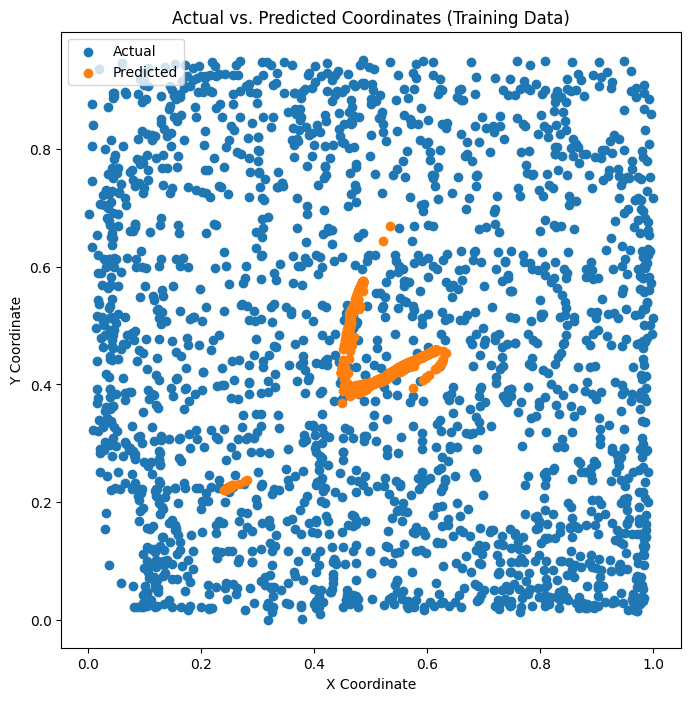

In [30]:
import matplotlib.pyplot as plt
import numpy as np

prediction = model.predict(train_ds) # Make predictions on train_ds
predicted_x, predicted_y = prediction[:, 0], prediction[:, 1]

# Get actual values from train_ds
actual_x_list = []
actual_y_list = []
for images, labels in train_ds: # Loop through train_ds
    actual_x_list.extend(labels[:, 0].numpy())
    actual_y_list.extend(labels[:, 1].numpy())

plt.figure(figsize=(8, 8))
plt.scatter(actual_x_list, actual_y_list, label="Actual")
plt.scatter(predicted_x, predicted_y, label="Predicted")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Actual vs. Predicted Coordinates (Training Data)") # Changed title
plt.legend()
plt.show()

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model

# Select a layer to visualize (e.g., the first Conv2D layer)
layer_name = "conv2d"  # Change this based on your model
layer_output = model.get_layer(layer_name).output

# Create a new model to get feature maps
feature_model = Model(inputs=model.input, outputs=layer_output)

# Get one random image from the dataset
for images, _ in train_ds.take(1):
    img = images[0:1]  # Keep batch dimension
    break

# Get feature maps
feature_maps = feature_model.predict(img)

# Plot the first few feature maps
num_filters = min(8, feature_maps.shape[-1])  # Show at most 8 feature maps
fig, axes = plt.subplots(1, num_filters, figsize=(15, 15))

for i in range(num_filters):
    ax = axes[i]
    ax.imshow(feature_maps[0, :, :, i], cmap="viridis")  # Show the ith filter
    ax.axis("off")
    ax.set_title(f"Filter {i+1}")

plt.show()


ValueError: No such layer: conv2d. Existing layers are: ['input_3', 'resizing_4', 'conv2d_14', 'conv2d_15', 'max_pooling2d_6', 'conv2d_16', 'conv2d_17', 'max_pooling2d_7', 'global_average_pooling2d_2', 'dense_6', 'dense_7', 'dense_8'].

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 3s 206ms/step


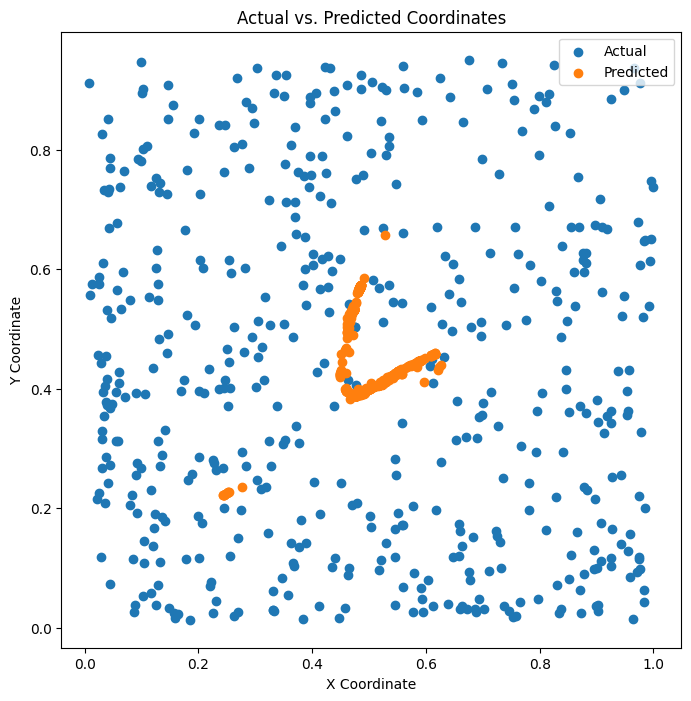

In [31]:
prediction = model.predict(val_ds)
predicted_x, predicted_y = prediction[:, 0], prediction[:, 1]

# Get actual values from val_ds
actual_x_list = []
actual_y_list = []
for images, labels in val_ds:
    actual_x_list.extend(labels[:, 0].numpy())
    actual_y_list.extend(labels[:, 1].numpy())

plt.figure(figsize=(8, 8))
plt.scatter(actual_x_list, actual_y_list, label="Actual")
plt.scatter(predicted_x, predicted_y, label="Predicted")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Actual vs. Predicted Coordinates")
plt.legend()
plt.show()